# Notebook examples for Chapter 7

In [1]:
%matplotlib inline

## Probabilistic label relaxation

In [ ]:
run scripts/classify -a 4 -p [1,2,3,4] -L [10,10] -P imagery/may0107pca.tif imagery/train.shp

In [ ]:
run scripts/plr imagery/may0107pca_classprobs.tif

In [ ]:
%run scripts/dispms -f imagery/may0107pca_class.tif -c -d [400,400,300,300] \
-F imagery/may0107pca_classprobs_plr.tif -C -D [400,400,300,300] \
-s '/home/mort/LaTeX/new projects/CRC4/Chapter7/fig7_1.eps'

## Accuracy assessment

In [ ]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

theta = 0.4
n = 2000
x = np.arange(600, 1000)
# pmf = probability mass function
plt.plot(x, binom.pmf(x, n, theta))

plt.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter7/fig7_2.eps')

In [ ]:
ls imagery

In [ ]:
run scripts/ct imagery/may0107pca_MaxLike.tst

### Crossvalidation

In [ ]:
run scripts/crossvalidate -p [1,2,3,4] -a 5 -e 3 -L [10,10] imagery/may0107pca.tif imagery/train.shp

In [ ]:
run scripts/classify -p [1,2,3,4] -a 4 -e 5000 -L [10] imagery/may0107pca.tif imagery/train.shp

In [ ]:
run scripts/classify -p [1,2,3,4] -a 6 -e 50000 -L [10,10] imagery/may0107pca.tif imagery/train.shp

In [ ]:
run scripts/mcnemar imagery/may0107pca_NNet(Congrad).tst imagery/may0107pca_MaxLike.tst

In [ ]:
run scripts/mcnemar imagery/may0107pca_NNet(Congrad).tst imagery/may0107pca_SVM.tst

In [ ]:
run scripts/mcnemar imagery/may0107pca_NNet(Congrad).tst imagery/may0107pca_Dnn(tensorflow).tst

In [ ]:
run scripts/classify -p [1,2,3,4] -a 4 -e 5000 -L [10] imagery/may0107pca.tif imagery/train.shp

In [ ]:
run scripts/classify -p [1,2,3,4] -a 6 -e 5000 -L [10] imagery/may0107pca.tif imagery/train.shp

In [ ]:
run scripts/mcnemar imagery/may0107pca_NNet(Congrad).tst imagery/may0107pca_Dnn(tensorflow).tst

## Adaptive boosting

In [ ]:
run scripts/adaboost -p [1,2,3,4,5,6]  -L [10] -n 75 imagery/may0107pca.tif  imagery/train.shp

In [ ]:
run scripts/dispms -f /home/mort/python/CRC4Docker/src/imagery/may0107pca_class.tif -c

## Hyperspectral image analysis

In [15]:
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly
import numpy as np
import matplotlib.pyplot as plt

inDataset = gdal.Open('myimagery/97_radianz_registriert_voll',GA_ReadOnly)                       
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize    
bands = inDataset.RasterCount
print rows, cols, bands

512 614 224


In [21]:
Im = np.zeros((rows,cols,bands)) 
for b in range(bands):
    band = inDataset.GetRasterBand(b+1)
    Im[:,:,b] = band.ReadAsArray(0,0,cols,rows)  

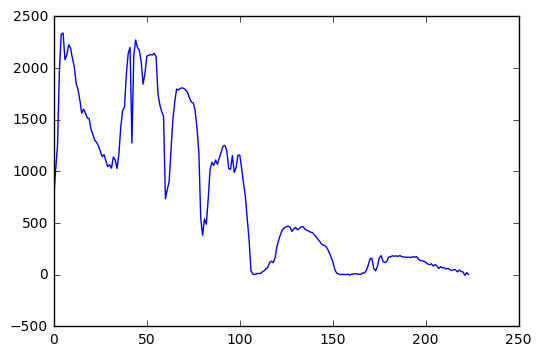

In [22]:
# spectral cut
plt.plot(Im[300,300,:])

------------MNF ---------------
Thu May 10 12:57:53 2018
Input myimagery/97_radianz_registriert_voll
Eigenvalues: [0.15847817 0.17458755 0.25539175 0.27990088 0.2981376  0.32026017
 0.32664865 0.340853   0.34312788 0.35967907 0.3694163  0.3726334
 0.39050987 0.41026488 0.41938815 0.4251202  0.43593526 0.43987006
 0.47525033 0.47951457 0.49884236 0.50340384 0.51449424 0.556238
 0.57330847 0.5932613  0.6110009  0.6227818  0.6328517  0.6386689
 0.64936393 0.6572146  0.66783273 0.6793858  0.68199265 0.6914482
 0.6986991  0.71057886 0.71453935 0.720185   0.7269166  0.7279883
 0.73086673 0.7334537  0.73444045 0.741484   0.7430232  0.7444169
 0.7451263  0.7461895  0.7471361  0.7482118  0.74854213 0.749243
 0.75007176 0.7507657  0.75108933 0.75161314 0.7522805  0.7532889
 0.75423974 0.7546025  0.7555383  0.7558921  0.7565272  0.75791615
 0.7581812  0.7588452  0.75963676 0.75984704 0.7607666  0.7611485
 0.7614176  0.7626308  0.7631559  0.763242   0.76409304 0.7649468
 0.7655087  0.7659575  0.76

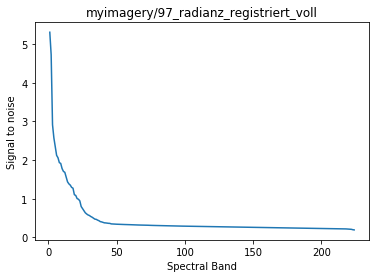

MNFs written to: myimagery/97_radianz_registriert_voll_mnf
elapsed time: 13.4372260571


In [5]:
run scripts/mnf.py myimagery/97_radianz_registriert_voll

### Anomaly detection

In [8]:
run scripts/rx imagery/may0107

------------ RX ---------------
Sun May 13 16:49:58 2018
Input imagery/may0107
Result written to imagery/may0107_rx
elapsed time: 0.410514116287


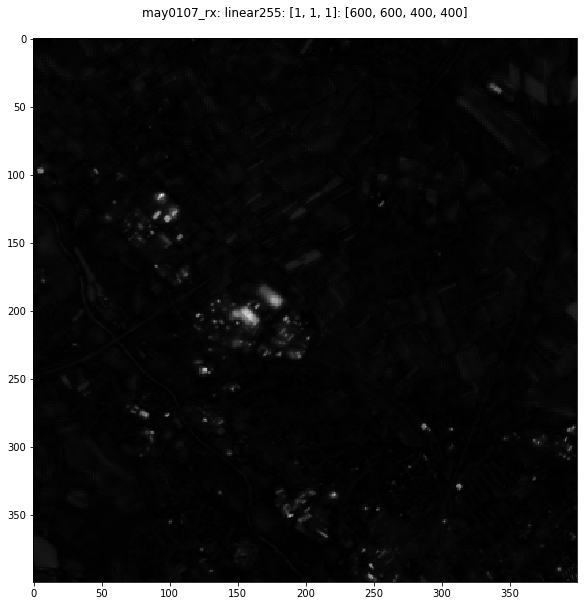

In [27]:
run scripts/dispms -f imagery/may0107_rx -e 1 -d [600,600,400,400]

In [17]:
run scripts/krx -s 2000 imagery/may0107

------------ KRX ---------------
Sun May 13 16:59:41 2018
Input imagery/may0107
GMA: 0.000003
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
Result written to imagery/may0107_krx
elapsed time: 199.017396927


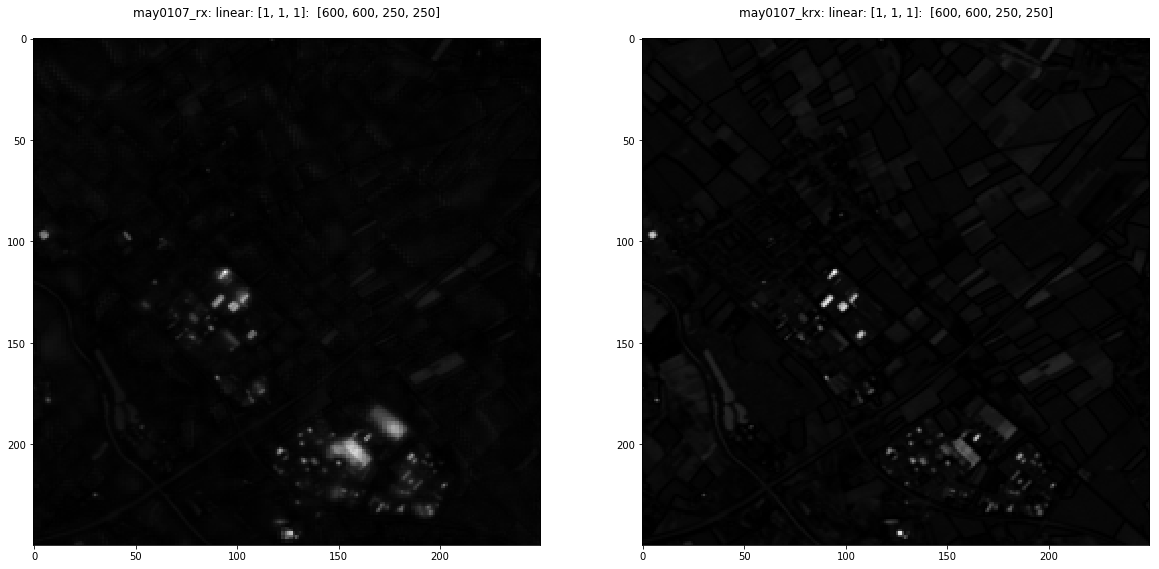

In [2]:
run scripts/dispms -f imagery/may0107_rx -e 2 -d [600,600,250,250] \
-F imagery/may0107_krx -E 2 -D [600,600,250,250] \
-s '/home/mort/LaTeX/new projects/CRC4/Chapter7/fig7_8.eps'